In [1]:
import numpy as np
import pandas as pd
from pandas.io import gbq

import seaborn as sns
import matplotlib.pyplot as plt

import re
from collections import Counter
import itertools

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import IsolationForest, RandomForestClassifier

%matplotlib inline

ModuleNotFoundError: No module named 'nltk'

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/daria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
### Confusion matrix graph function

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True popular')
    plt.xlabel('Predicted popular')
    plt.show()

In [ ]:
### ROC curve plotting function

def plot_roc(mod, X, y, varname):
    mod.fit(X, y)
    y_pp = mod.predict_proba(X)[:, 1]
    fpr_, tpr_, _ = roc_curve(y, y_pp)
    auc_ = auc(fpr_, tpr_)
    acc_ = np.abs(0.5 - np.mean(y)) + 0.5
    
    fig, axr = plt.subplots(figsize=(8,7))

    axr.plot(fpr_, tpr_, label='ROC (area = %0.2f)' % auc_,
             color='darkred', linewidth=4,
             alpha=0.7)
    axr.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=4, label='baseline accuracy = %0.2f' % acc_)

    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('false positive rate', fontsize=16)
    axr.set_ylabel('true positive rate', fontsize=16)
    axr.set_title(varname+' vs. not ROC curve\n', fontsize=20)

    axr.legend(loc="lower right", fontsize=12)

    plt.show()

In [ ]:
### Classification metrics report function

def classification_metrics(model, x_test_set, y_test_set, predictions):
    plot_confusion_matrix(confusion_matrix(y_test_set, predictions), classes=[0,1,2])
    print("Accuracy score: "), print(accuracy_score(y_test_set, predictions))
    #print("Baseline: "), print(max(np.mean(y_test_set),(1-np.mean(y_test_set))))
    print(classification_report(y_test_set, predictions))
    #plot_roc(model, x_test_set, y_test_set, 'popularity')

In [ ]:
release_schedule = pd.read_clipboard()

In [ ]:
release_schedule.head()

In [ ]:
release_schedule.to_csv('release_schedule.csv', index=False)

In [4]:
release_schedule = pd.read_csv('release_schedule.csv', index_col=False)
release_schedule

,Release Date,UPC,Title/Theme
0,11/23/2016,00602557103601,Christmas
1,12/9/2016,00602557342697,Christmas Blues
2,12/9/2016,00602557342703,Christmas Jazz
3,1/27/2017,00602557414387,Crowd Pleasers
4,2/3/2017,00602557437638,Let Me Love You Old School
5,2/10/2017,00602557449297,Hip Hop Hit List
6,2/17/2017,00602557462098,Shut Up Lets Dance
7,2/24/2017,00602557474404,Fiesta Latina
8,3/3/2017,00602557530711,Hip Hop Hit List (Re-release)
9,5/26/2017,00602557688849,Blues Gold


In [ ]:
release_schedule.UPC.unique()

In [5]:
sources = ['7 Digital',
'7digital Limited',
'Apple',
'iTunes',
'Amazon',
'Deezer',
'Spotify',
'YouTube',
'Google',
'Napster by Rhapsody']

In [6]:
swift_sql = "SELECT * FROM `umg-comm-tech-dev.fixed_playlists.stats_swift_consumption`"
data = gbq.read_gbq(query=swift_sql, project_id='umg-comm-tech-dev', dialect='standard')
data.head()

,upc,sub_account_name,year,month,euro_amount,total_streams,release_date,title_theme,year_month,reports_date,playlist_lifetime_months,max_monthly_streams,popularity_quantile
0,00602557779721,Apple,2007,12,-0.505,-1,2017-07-07,90s Mixtape,200712,2007-12-01,-115,6291535,most_popular
1,00602567132547,YouTube,2010,07,0.000,1,2017-11-10,Hip Hop 2000,201007,2010-07-01,-88,564132,most_popular
2,00602567132547,YouTube,2010,09,11.052,16062,2017-11-10,Hip Hop 2000,201009,2010-09-01,-86,564132,most_popular
3,00602567132547,YouTube,2010,10,18.241,28217,2017-11-10,Hip Hop 2000,201010,2010-10-01,-85,564132,most_popular
4,00602567132547,YouTube,2010,11,18.905,36214,2017-11-10,Hip Hop 2000,201011,2010-11-01,-84,564132,most_popular


In [ ]:
by_upc_account_year_month = data.groupby(by=['upc','sub_account_name','year','month'])

In [ ]:
summed_data = by_upc_account_year_month.sum().reset_index()

In [ ]:
summed_data.head()

In [ ]:
summed_data.shape

In [ ]:
summed_data.to_csv('upc_account_date.csv')

In [ ]:
summed_data = pd.read_csv('upc_account_date.csv', index_col='Unnamed: 0', dtype={'upc':str})
release_schedule = pd.read_csv('release_schedule.csv', dtype={'UPC':str})

In [ ]:
release_schedule.UPC.dtype

In [ ]:
summed_data.upc.dtype

In [ ]:
summed_data.head()

In [ ]:
summed_data = summed_data.merge(release_schedule, how='left', left_on = 'upc', right_on = 'UPC')
summed_data = summed_data.drop(columns = 'UPC')


In [ ]:
summed_data['month'] = [str(x) if x > 9 else '0'+str(x) for x in summed_data.month]

In [ ]:
summed_data['year_month'] = [str(x)+str(y) for x,y in zip(summed_data.year, summed_data.month)]
summed_data.head()

In [ ]:
by_upc_account = summed_data.groupby(by=['upc','sub_account_name']).year_month.nunique().describe()

In [ ]:
by_upc_account

In [ ]:
summed_data = summed_data.rename(columns={'Release Date':'release_date', 'Title/Theme':'title_theme'})

In [ ]:
summed_data.groupby(by=['upc','sub_account_name']).total_streams.mean().describe()

In [ ]:
summed_data['release_date'] = pd.to_datetime(summed_data['release_date'])

In [ ]:
summed_data['reports_date'] = pd.to_datetime(summed_data[['year', 'month']].assign(day=1))
summed_data.head()

In [ ]:
summed_data['playlist_lifetime_months'] = ((summed_data.reports_date - summed_data.release_date)/np.timedelta64(1, 'M'))

In [ ]:
summed_data['playlist_lifetime_months'] = np.round(summed_data.playlist_lifetime_months, decimals=0)
summed_data['playlist_lifetime_months'] = summed_data['playlist_lifetime_months'].fillna(0)
summed_data['playlist_lifetime_months'] = [int(x) for x in summed_data.playlist_lifetime_months]

In [ ]:
summed_data.head()

In [ ]:
max_streams = summed_data.groupby(by=['upc']).total_streams.max().reset_index()

In [ ]:
print(summed_data.groupby(by=['upc']).total_streams.max().quantile(0.25))
print(summed_data.groupby(by=['upc']).total_streams.max().quantile(0.75))

In [ ]:
max_streams['quantile'] = ''

quant_25 = summed_data.groupby(by=['upc']).total_streams.max().quantile(0.25)
quant_75 = summed_data.groupby(by=['upc']).total_streams.max().quantile(0.75)

for i in range(max_streams.shape[0]):
    if max_streams['total_streams'][i] > quant_75:
        max_streams['quantile'][i] = 'most_popular'
    elif max_streams['total_streams'][i] < quant_25:
        max_streams['quantile'][i] = 'least_popular'
    else:
        max_streams['quantile'][i] = 'middle_popular'
        
max_streams.head()

In [ ]:
summed_data = summed_data.merge(max_streams, how='left', on='upc')

In [ ]:
summed_data = summed_data.rename(columns={'total_streams_y':'max_monthly_streams'})
summed_data.head()

In [ ]:
gbq.to_gbq(summed_data, 'fixed_playlists.stats_swift_consumption', if_exists='replace', 
           project_id='umg-comm-tech-dev')

In [ ]:
test = summed_data[summed_data.upc=='00602567171706']

In [ ]:
test

In [ ]:
sns.relplot(x="playlist_lifetime_months", y="total_streams",
            hue="sub_account_name",
            height=5, aspect=.75, facet_kws=dict(sharex=False),
            kind="line", legend="full", data=test)

In [ ]:
df1 = summed_data.groupby(by=['popularity_quantile','sub_account_name','playlist_lifetime_months']).total_streams.mean().reset_index()
df2=df1[df1.playlist_lifetime_months>-10]

In [ ]:
summed_data.sub_account_name.unique()

In [ ]:
final_partners = ['Deezer', 'Spotify', 'Google', 'Amazon', 'Apple',
       'Napster by Rhapsody', 'YouTube']
df3 = df2[df2.sub_account_name.isin(final_partners)]

In [ ]:
df3.head()

In [ ]:
df3 = df3.rename(columns={'total_streams':'monthly_streams'})

In [ ]:
g = sns.relplot(x="playlist_lifetime_months", y="monthly_streams",
            hue="sub_account_name", col='popularity_quantile',
            height=7, aspect=.75, facet_kws=dict(sharex=False),
            kind="line", legend="full", data=df3)
g.fig.get_axes()[0].set_yscale('log')
plt.show()

In [ ]:
df4 = df3.groupby(by=['popularity_quantile','playlist_lifetime_months']).monthly_streams.sum().reset_index()

In [ ]:
df4.head()

In [ ]:
g1 = sns.catplot(data=df4, x='popularity_quantile', y='monthly_streams', kind='box')
g1.fig.get_axes()[0].set_yscale('log')
plt.show()

In [ ]:
track_data_sql = "SELECT * FROM `umg-comm-tech-dev.fixed_playlists.track_level_streams`"
track_data = gbq.read_gbq(query=track_data_sql, project_id='umg-comm-tech-dev', dialect='standard')

In [10]:
track_data.head()

,upc,isrc,year,month,monthly_streams
0,00602557462098,USUM71607007,2018,01,1537073
1,00602557462098,USUM71607007,2019,01,1149840
2,00602557814477,USUM71703088,2018,01,652934
3,00602557760347,USUM71709101,2018,01,629185
4,00602567108252,USUM71709292,2018,01,602605


In [8]:
data.head()

,upc,sub_account_name,year,month,euro_amount,total_streams,release_date,title_theme,year_month,reports_date,playlist_lifetime_months,max_monthly_streams,popularity_quantile
0,00602557779721,Apple,2007,12,-0.505,-1,2017-07-07,90s Mixtape,200712,2007-12-01,-115,6291535,most_popular
1,00602567132547,YouTube,2010,07,0.000,1,2017-11-10,Hip Hop 2000,201007,2010-07-01,-88,564132,most_popular
2,00602567132547,YouTube,2010,09,11.052,16062,2017-11-10,Hip Hop 2000,201009,2010-09-01,-86,564132,most_popular
3,00602567132547,YouTube,2010,10,18.241,28217,2017-11-10,Hip Hop 2000,201010,2010-10-01,-85,564132,most_popular
4,00602567132547,YouTube,2010,11,18.905,36214,2017-11-10,Hip Hop 2000,201011,2010-11-01,-84,564132,most_popular


In [ ]:
len(track_data.upc.unique())

In [ ]:
track_data.groupby(by='upc').isrc.count().describe()

In [19]:
by_upc_date = data.groupby(by=['upc','year','month'])

In [22]:
summed_data_num = by_upc_date[['euro_amount','total_streams']].sum().reset_index()

In [24]:
summed_data_qual = by_upc_date[['release_date','title_theme','year_month','reports_date','playlist_lifetime_months',
                               'max_monthly_streams','popularity_quantile']].max().reset_index()

In [25]:
summed_data = summed_data_num.merge(summed_data_qual, how='left', on=['upc','year','month'])

In [26]:
summed_data.head()

,upc,year,month,euro_amount,total_streams,release_date,title_theme,year_month,reports_date,playlist_lifetime_months,max_monthly_streams,popularity_quantile
0,00600406836304,2018,09,11.486,7721,2018-05-04,Blues For Breakfast,201809,2018-09-01,4,7715,least_popular
1,00600406836304,2018,10,8.687,6403,2018-05-04,Blues For Breakfast,201810,2018-10-01,5,7715,least_popular
2,00600406836304,2018,11,10.536,7666,2018-05-04,Blues For Breakfast,201811,2018-11-01,6,7715,least_popular
3,00600406836304,2018,12,12.628,7335,2018-05-04,Blues For Breakfast,201812,2018-12-01,7,7715,least_popular
4,00600406836304,2019,01,2.143,1275,2018-05-04,Blues For Breakfast,201901,2019-01-01,8,7715,least_popular


In [9]:
track_data['year']=[str(x) for x in track_data.year]
track_data['month'] = [str(x) if x > 9 else '0'+str(x) for x in track_data.month]

In [29]:
data['year']=[str(x) for x in data.year]

In [28]:
data.year.dtype

dtype('int64')

In [30]:
all_data = data[data.sub_account_name=='Spotify'].merge(track_data, how='left', on=['upc','year','month'])
all_data.head()

,upc,sub_account_name,year,month,euro_amount,total_streams,release_date,title_theme,year_month,reports_date,playlist_lifetime_months,max_monthly_streams,popularity_quantile,isrc,monthly_streams
0,00602567132547,Spotify,2013,05,0.008,1,2017-11-10,Hip Hop 2000,201305,2013-05-01,-54,564132,most_popular,NaN,nan
1,00602567394037,Spotify,2014,11,0.141,40,2018-02-02,Anti-Valentine,201411,2014-11-01,-39,1174350,most_popular,NaN,nan
2,00602567132547,Spotify,2014,12,0.008,3,2017-11-10,Hip Hop 2000,201412,2014-12-01,-35,564132,most_popular,NaN,nan
3,00602567394037,Spotify,2014,12,0.128,38,2018-02-02,Anti-Valentine,201412,2014-12-01,-38,1174350,most_popular,NaN,nan
4,00602567132547,Spotify,2015,01,0.016,7,2017-11-10,Hip Hop 2000,201501,2015-01-01,-34,564132,most_popular,NaN,nan


In [31]:
all_data['streams_perc'] = all_data.monthly_streams/all_data.total_streams

In [33]:
perc_clean = all_data[(all_data.streams_perc>0)&(all_data.streams_perc<=1)]

In [50]:
perc_clean.groupby(by='popularity_quantile').streams_perc.describe()

,count,mean,std,min,25%,50%,75%,max
popularity_quantile,,,,,,,,
least_popular,7871.000,0.047,0.077,0.001,0.021,0.031,0.047,1.000
middle_popular,29160.000,0.060,0.103,0.000,0.019,0.033,0.057,1.000
most_popular,23661.000,0.056,0.112,0.000,0.010,0.024,0.051,1.000


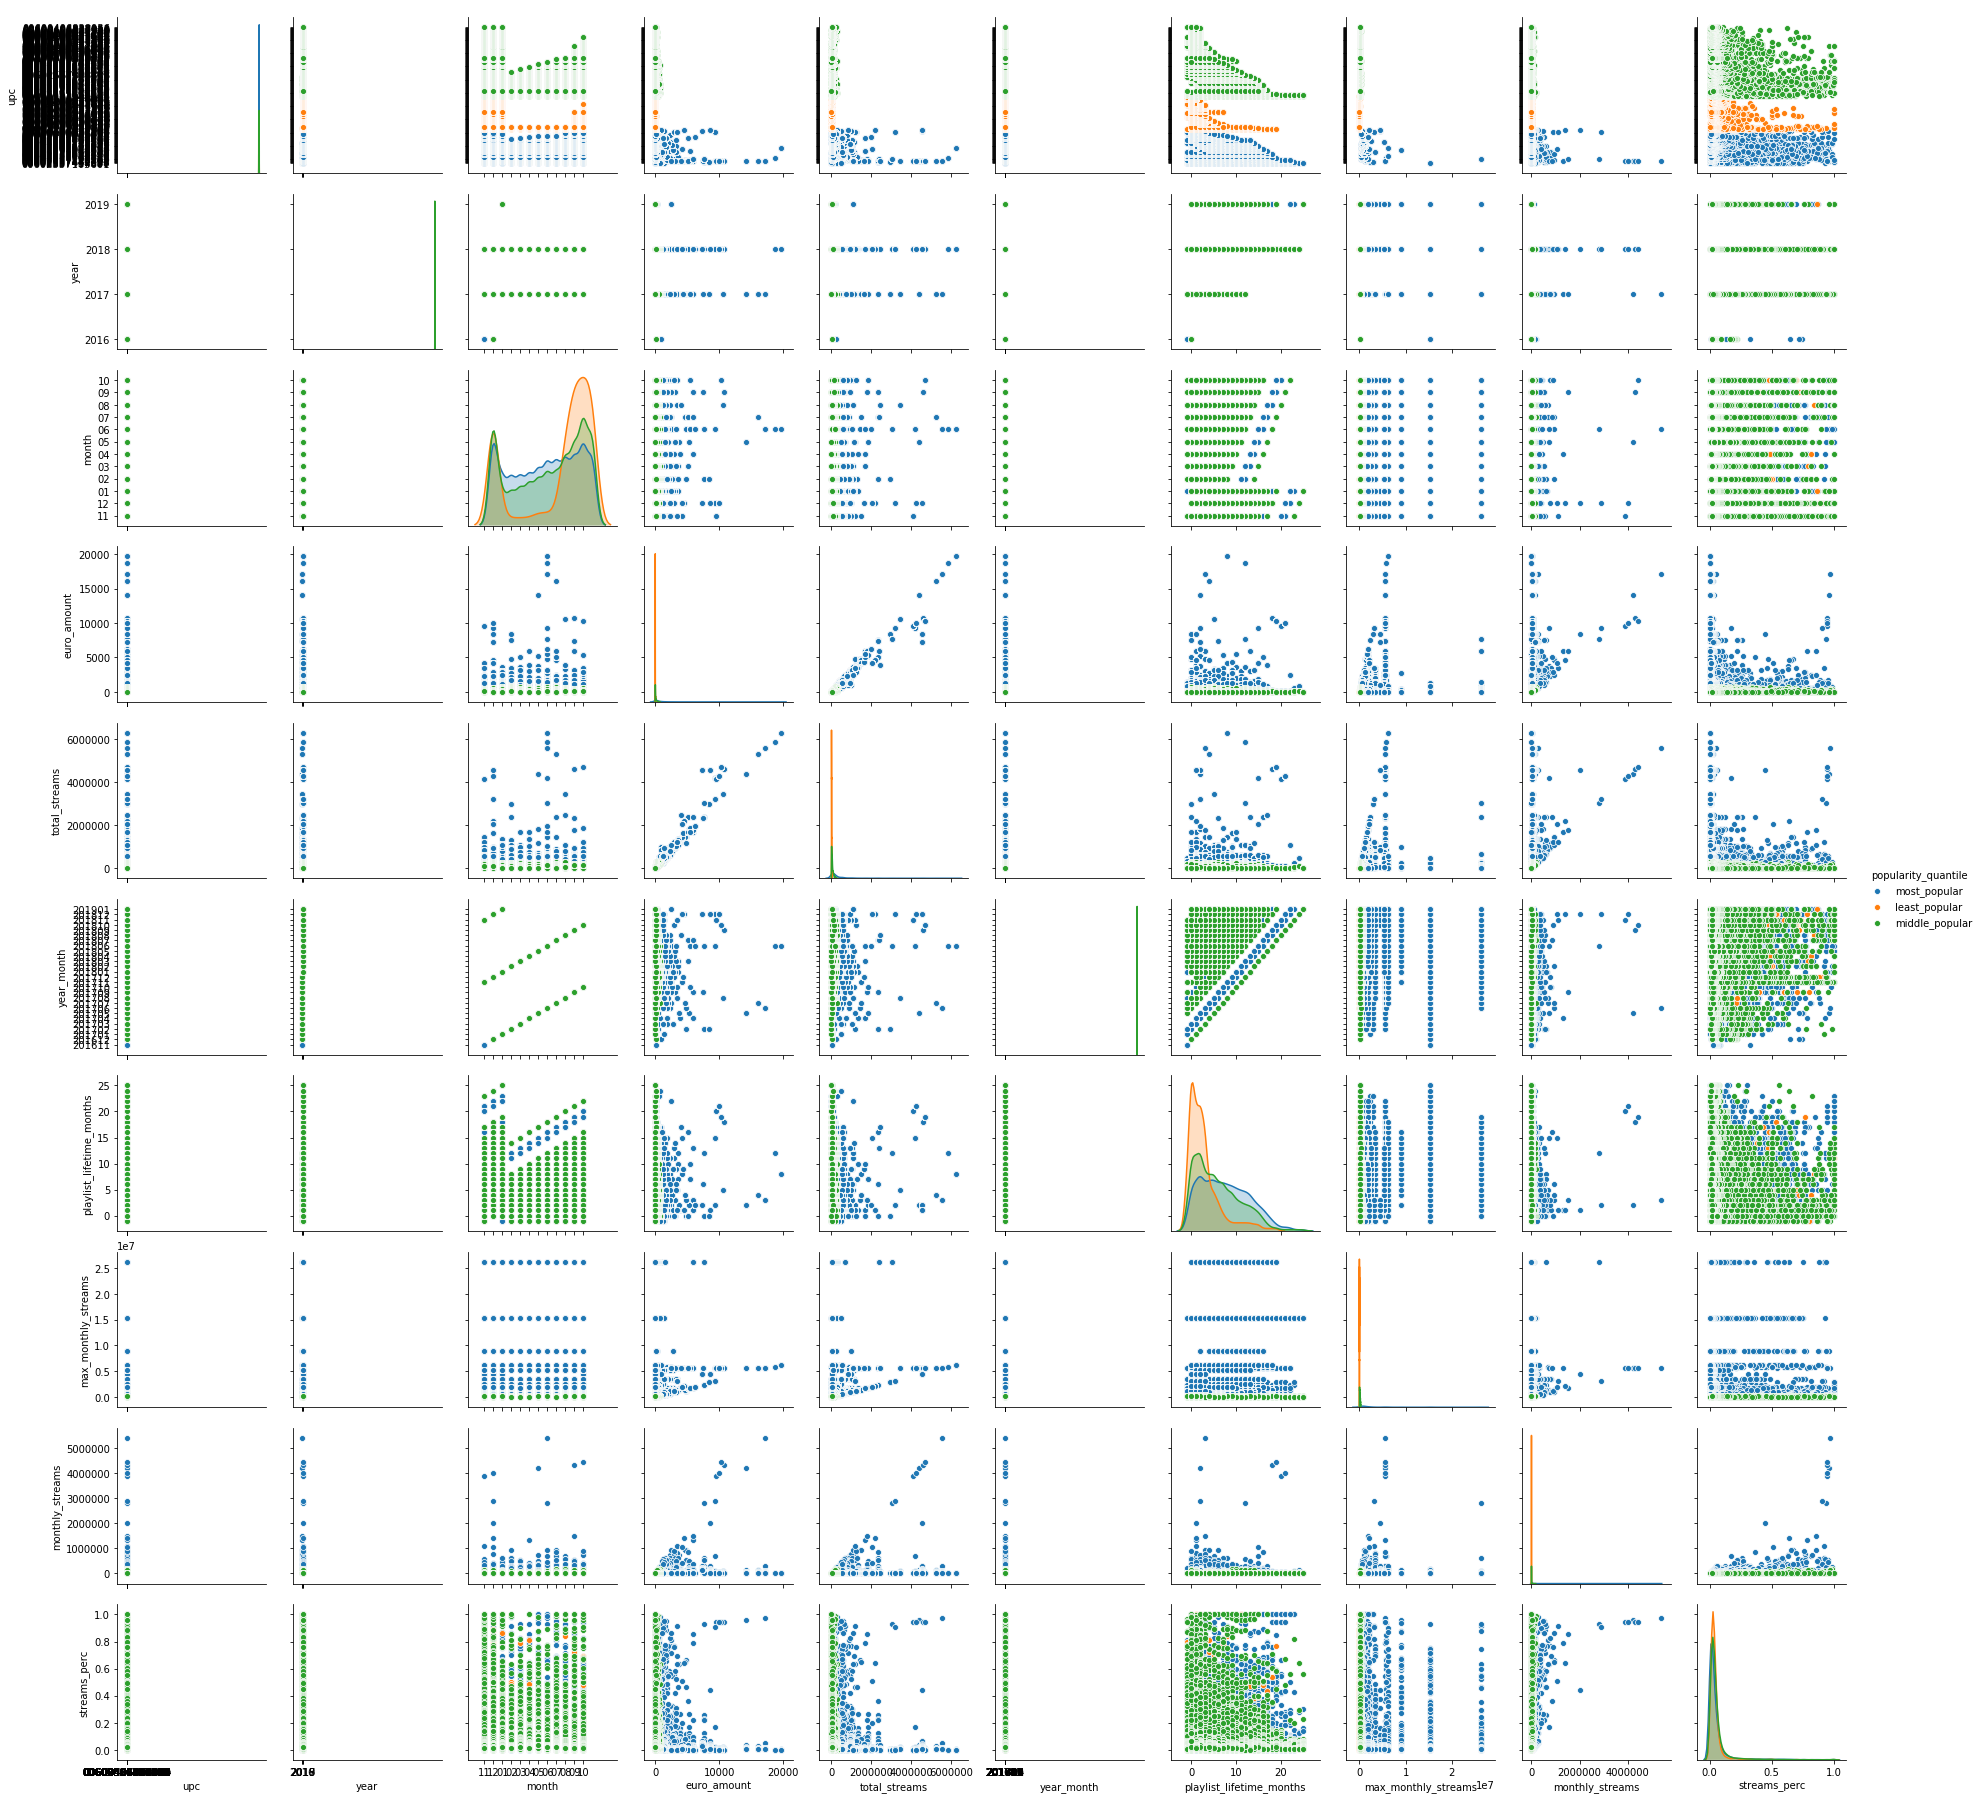

In [56]:
sns.pairplot(perc_clean, hue='popularity_quantile')

In [57]:
isrcs = pd.concat([nineties_rock,shape_of_pop,christmas], ignore_index=True)
isrcs.isrc.unique()

array(['USGF19962907', 'USGF19463401', 'USIR19200553', 'USCA29200194',
       'GBAAA9700049', 'USIR19600462', 'USMR19130361', 'USMR19780102',
       'USVI21100146', 'USAM19400007', 'USCA29600428', 'USIR19400529',
       'USAT29400023', 'USIR29600091', 'USIR19915025', 'USIR29400443',
       'USIR19500272', 'USAM19400296', 'GBF089400272', 'GBF089390003',
       'USAM19090000', 'USUM71700626', 'USUM71703825', 'USUM71602110',
       'USUM71701375', 'USUM71703401', 'USUM71702295', 'USUM71704121',
       'USHR11737926', 'USUM71704474', 'USUM71702833', 'GBUM71701777',
       'USUM71616357', 'USUM71703935', 'USUG11700631', 'USUM71705045',
       'USUM71703644', 'USUM71701080', 'USUM71116290', 'USMC15746480',
       'USMC15848998', 'USMO17082641', 'USJAY0500789', 'USCA25900140',
       'USMC16414508', 'USMC14750470', 'USCA20200937', 'USMO19383282',
       'USCA21300239', 'USCA25900260', 'USF096025290', 'USUM71512074',
       'USMO17082669', 'USCA28900496', 'USMO16782670', 'USCA29900551',
      

In [59]:
meta = pd.read_csv('/Users/daria/Downloads/results-20190122-145047.csv')

,track_isrc,artist_name,track_name
0,USIR19200553,4 Non Blondes,What's Up?
1,USCA29200194,Blind Melon,No Rain
2,USUM71703401,DNCE,Kissing Strangers
3,USMC15746480,Bobby Helms,Jingle Bell Rock
4,USMC14447439,Judy Garland,"Have Yourself A Merry Little Christmas - ""Meet..."


In [67]:
meta['artist_title'] = [str(x)+' - '+str(y) for (x,y) in zip(meta.artist_name, meta.track_name)]
meta = meta.drop_duplicates(subset=['track_isrc'])
meta.head()

,track_isrc,artist_name,track_name,artist_title
0,USIR19200553,4 Non Blondes,What's Up?,4 Non Blondes - What's Up?
1,USCA29200194,Blind Melon,No Rain,Blind Melon - No Rain
2,USUM71703401,DNCE,Kissing Strangers,DNCE - Kissing Strangers
3,USMC15746480,Bobby Helms,Jingle Bell Rock,Bobby Helms - Jingle Bell Rock
4,USMC14447439,Judy Garland,"Have Yourself A Merry Little Christmas - ""Meet...",Judy Garland - Have Yourself A Merry Little Ch...


In [68]:
nineties_rock = perc_clean[perc_clean.upc=='00602567171706']
shape_of_pop = perc_clean[perc_clean.upc=='00602557728149']
christmas = perc_clean[perc_clean.upc=='00602557103601']

In [69]:
nineties_rock = nineties_rock.merge(meta, how='left', left_on = 'isrc', right_on='track_isrc')
shape_of_pop = shape_of_pop.merge(meta, how='left', left_on = 'isrc', right_on='track_isrc')
christmas = christmas.merge(meta, how='left', left_on = 'isrc', right_on='track_isrc')

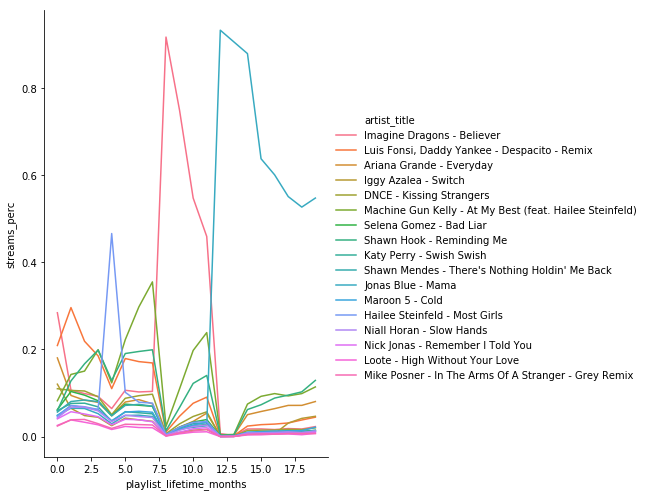

In [70]:
sns.relplot(x="playlist_lifetime_months", y="streams_perc",
            hue="artist_title",
            height=7, aspect=.75, facet_kws=dict(sharex=False),
            kind="line", legend="full", data=shape_of_pop)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


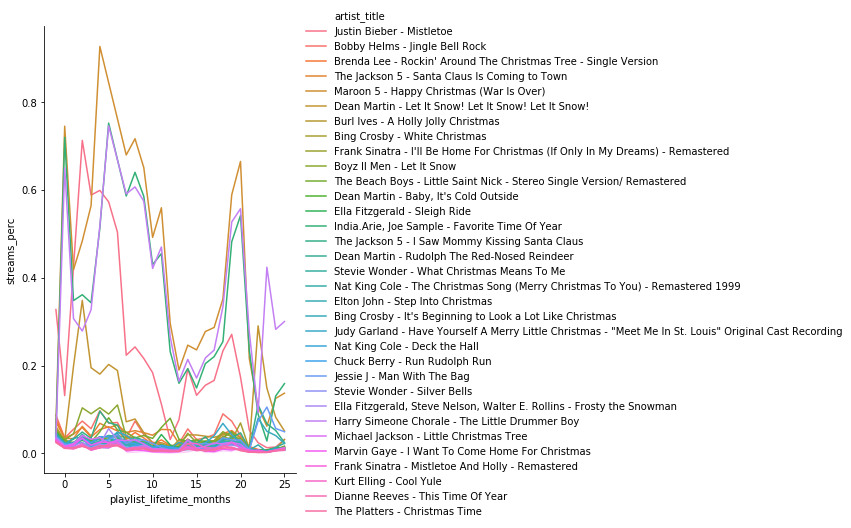

In [71]:
sns.relplot(x="playlist_lifetime_months", y="streams_perc",
            hue="artist_title",
            height=7, aspect=.75, facet_kws=dict(sharex=False),
            kind="line", legend="full", data=christmas)

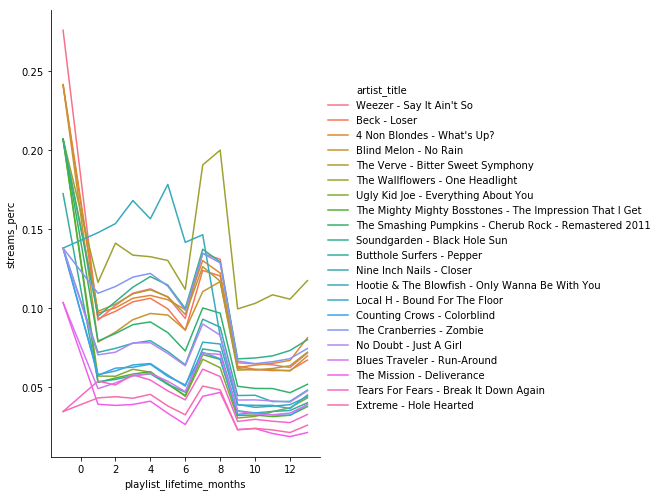

In [72]:
sns.relplot(x="playlist_lifetime_months", y="streams_perc",
            hue="artist_title",
            height=7, aspect=.75, facet_kws=dict(sharex=False),
            kind="line", legend="full", data=nineties_rock)

In [49]:
perc_clean.to_csv('track_level_streams.csv', index=False)

In [ ]:
df = track_data_upc2[['title_theme','quantile']].drop_duplicates()
df=df.reset_index(drop=True)
df['quantile_num'] = 0

for i in range(df.shape[0]):
    if df['quantile'][i] == 'middle_popular':
        df['quantile_num'][i] = 1
    elif df['quantile'][i] == 'most_popular':
        df['quantile_num'][i] = 2

In [ ]:
df.describe()

In [ ]:
stemmer = PorterStemmer()
words = stopwords.words("english")

df['title_theme'] = [str(x) for x in df.title_theme]

df['cleaned'] = df['title_theme'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z0-9]", " ", x).split() if i not in words]).lower())

In [ ]:
df.head()

In [ ]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 3))
final_features = vectorizer.fit_transform(df['cleaned']).toarray()
final_features.shape

In [ ]:
X = final_features
y = df['quantile_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

In [ ]:
gs_params_rfc = {
    'n_estimators' : [5,10,15],
    'max_depth' : [5,10,None],
    'class_weight': ['balanced'],
    'verbose' : [1]
}

model = RandomForestClassifier()

In [ ]:
gs = GridSearchCV(model, param_grid=gs_params_rfc, verbose = 1, n_jobs=2)
gs.fit(X_train, y_train)

In [ ]:
predict = gs.predict(X_test)

In [ ]:
classification_metrics(gs.best_estimator_, X_test, y_test, predict)

In [ ]:
coefs = list(zip(importances, cols))

In [ ]:
cols = vectorizer.get_feature_names()

In [ ]:
pd.DataFrame(coefs, columns=['coef','feature']).sort_values(by='coef', ascending=False)

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LogisticRegressionCV

In [ ]:
logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear']
}
logreg2=LogisticRegression()
gs_lr=GridSearchCV(logreg2,logreg_parameters,cv=5,verbose=1)
gs_lr.fit(X_train,y_train)

In [ ]:
predict = gs_lr.predict(X_test)\

In [ ]:
classification_metrics(gs_lr, X_test, y_test, predict)

In [ ]:
coefs = list(zip(gs_lr.best_estimator_.coef_[1], cols))

In [ ]:
pd.DataFrame(coefs, columns=['coef','feature']).sort_values(by='coef', ascending=False)

In [ ]:
df[df.cleaned.str.contains('christ')]

In [ ]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
text = pd.DataFrame(coefs, columns=['coef','feature']).sort_values(by='coef', ascending=False)
text_pos = text[text.coef>0].reset_index(drop=True)
text_neg = text[text.coef<0].reset_index(drop=True)

In [ ]:
text_pos_input = ' '.join(text_pos.feature)
text_neg_input = ' '.join(text_neg.feature)

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_pos_input)

In [ ]:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
wordcloud2 = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(text_neg_input)
plt.figure()
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()